# Project Method 3: Applied to CCU

This notebook generates the hourly number of arrivals using a Poisson distribution for each hour. This is applied to the example from thr CCU weekday dataset.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sim_tools.datasets import load_banks_et_al_nspp
import sim_tools
sim_tools.__version__

/tmp/ipykernel_473198/3514245499.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


'0.5.0'

## Arrival Profile Data

We will use the `arrival_rate` column as the parameter of the individual Poisson distributions.

In [2]:
ccu_arrival_profile_week = pd.read_csv('./data/weekday_profile.csv')
ccu_arrival_profile_week.round(1)

,t,arrival_rate,mean_iat
0,0,1.1,55.5
1,60,1.3,46.1
2,120,0.9,69.3
3,180,0.9,67.2
4,240,0.7,85.1
5,300,0.7,81.1
6,360,0.7,90.0
7,420,0.5,115.1
8,480,0.4,145.0
9,540,0.4,141.1


## Sampler

A class has been created to simplify the sampling.

In [3]:
class HourPoissonSampler:
    def __init__(self, arrival_profile, random_seed=None):
        self.arrival_profile = arrival_profile
        self.rng = np.random.default_rng(random_seed)

    def sample(self, hour, size=None):
        '''Sample the number of arrivals in a given hour

        Parameters:
        ---------
        hour: int
            Zero indexed hour

        size: int, optional (default=None)
            Number of samples to return. None returns 1.

        Returns:
        -------
        np.array or float
        
        '''
        rate = self.arrival_profile.iloc[hour]['arrival_rate']
        return self.rng.poisson(rate, size=size)
    

## Using the sampler

In [4]:
samples_per_hour = 100_000

# create the sampler and set seed
ph_sampler = HourPoissonSampler(ccu_arrival_profile_week, random_seed=42)

# returns numpy array for hour 1
hr_sample = ph_sampler.sample(0, size=samples_per_hour)
hr_sample.shape

(100000,)

In [5]:
# first 10 results
hr_sample[:10]

array([2, 1, 3, 1, 3, 0, 1, 3, 3, 1])

In [6]:
# mean arrival rate as expected - its our rate parameter og 0.067 per hr.
hr_sample.mean().round(1)

1.1

## Sampling experiment

In [7]:
ph_sampler = HourPoissonSampler(ccu_arrival_profile_week, random_seed=42)

samples = []
for hr in range(len(ccu_arrival_profile_week)):
    hr_sample = ph_sampler.sample(hr, size=samples_per_hour)
    samples.append(hr_sample)



## Plot results

The hour means are our theorectical arrival rates per hour - as expected.

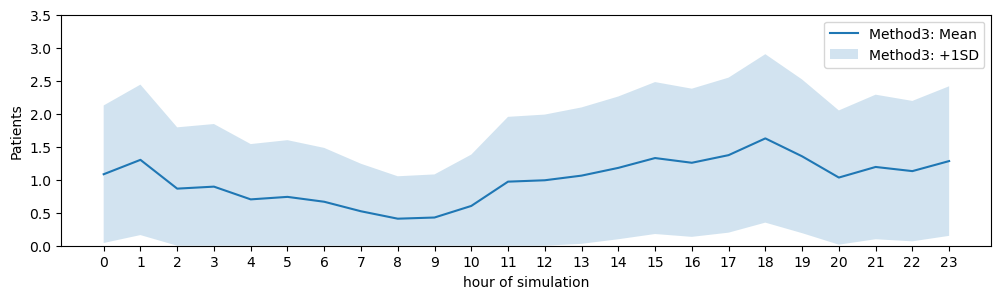

In [18]:
# get hour means
hour_means = np.asarray(samples).mean(axis=1)
hour_sd = np.asarray(samples).std(axis=1) 

upper = hour_means + hour_sd
lower = hour_means - hour_sd
lower[lower < 0] = 0

x_values = np.arange(0, ccu_arrival_profile_week.shape[0])

# visualise
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

# plot in this case returns a 2D line plot object
_ = ax.plot(hour_means, label='Method3: Mean')
_ = ax.fill_between(x_values, lower, upper, alpha=0.2, label='Method3: +1SD')
_ = ax.set_ylim(0, 3.5)
_ = plt.xticks(np.arange(0, ccu_arrival_profile_week.shape[0]))
_ = ax.set_ylabel("Patients")
_ = ax.set_xlabel("hour of simulation")
_ = ax.legend()

In [ ]:
pd.DataFrame(hour_means).to_csv("./ccu_method3.csv", index=False)
